In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as pycaps_radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
import pyart
import cartopy.crs as ccrs

In [24]:
radar_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/ARMOR/0327/CFRadial'
radar_filename = 'cfrad.20170327_195601.883_to_20170327_195835.448_ARMOR_FV-N_SUR.nc'
radar_path = os.path.join(radar_dir, radar_filename)
radarobj = pyart.io.read_cfradial(radar_path)

In [44]:
elevs = radarobj.elevation['data']
elev_list = []
for elev in radarobj.iter_elevation():
    elev_list.append(elev[-1])

radarsweep = radarobj.extract_sweeps([0])
print(radarsweep.elevation['data'])
#     # Try to match up requested elevation angle with one in the file
#     # Pick closest elevation angle to that requested
#     elev_list = []
#     for elev in radarobj.iter_elevation():
#         elev_list.append(elev[0])  # Just grab the elevation of the first ray in each sweep
#     elev_list = np.array(elev_list)

[0.7003784  0.6893921  0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234
 0.68115234 0.68115234 0.68115234 0.68115234 0.68115234 0.6811

In [45]:
print(radarsweep.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	units: meters
	_FillValue: -9999.0
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	units: meters
	_FillValue: -9999.0
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (360,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (360,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (360,)>
	long_name: ray_elevation_angle
	units: degrees
	_FillValue: -9999.0
	positive: up
fields:
	DBZ_TOT:
		data: <ndarray of type: float32 and shape: (360, 992)>
		units: dBZ
		sampling_ratio: 1.0
		_FillValue: -128
		grid_mapping: grid_mapping
		coordinates: time range
	DBZ:
		data: <ndarray of type: float32 and shape: (360,

Time:  2017-03-27T19:56:01Z
Elevation:  0.6591797


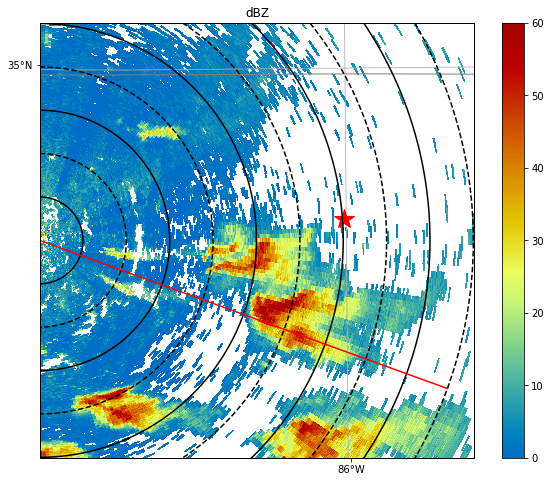

In [46]:
PIPS_lat = 34.687122998603364
PIPS_lon = -86.00486622375519
sweeptime = radarsweep.metadata['start_datetime']
display = pyart.graph.RadarMapDisplay(radarsweep)
fig = plt.figure(figsize=(10, 8))

projection = ccrs.LambertConformal(central_latitude=radarsweep.latitude['data'][0],
                                   central_longitude=radarsweep.longitude['data'][0])

ax = fig.add_subplot(111)
print("Time: ", sweeptime)
print("Elevation: ", radarsweep.elevation['data'][-1])
display.plot_ppi_map('DBZ', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
                     vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                     fig=fig)
display.ax.set_extent([0, 100000, -50000, 50000], crs=projection)
display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
display.plot_range_ring(10., line_style='k-')
display.plot_range_ring(20., line_style='k--')
display.plot_range_ring(30., line_style='k-')
display.plot_range_ring(40., line_style='k--')
display.plot_range_ring(50., line_style='k-')
display.plot_range_ring(60., line_style='k--')
display.plot_range_ring(70., line_style='k-')
display.plot_range_ring(80., line_style='k--')
display.plot_range_ring(90., line_style='k-')
display.plot_range_ring(100., line_style='k--')
ray = np.arange(0., 101000., 1000.)
angle = (90. - 110.) * np.pi / 180.
x_ray = np.cos(angle) * ray
y_ray = np.sin(angle) * ray
# print(x_ray, y_ray)
display.plot_line_xy(x_ray, y_ray)

Time:  2017-03-27T19:56:01Z
Elevation:  0.6591797


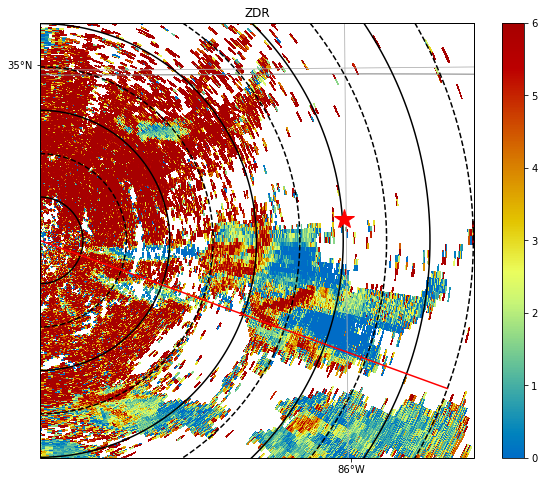

In [54]:
display = pyart.graph.RadarMapDisplay(radarsweep)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
print("Time: ", sweeptime)
print("Elevation: ", radarsweep.elevation['data'][-1])
display.plot_ppi_map('ZDR', 0, title='ZDR', cmap='pyart_HomeyerRainbow',
                     vmin=0., vmax=6, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                     fig=fig)
display.plot_range_ring(10., line_style='k-')
display.plot_range_ring(20., line_style='k--')
display.plot_range_ring(30., line_style='k-')
display.plot_range_ring(40., line_style='k--')
display.plot_range_ring(50., line_style='k-')
display.plot_range_ring(60., line_style='k--')
display.plot_range_ring(70., line_style='k-')
display.plot_range_ring(80., line_style='k--')
display.plot_range_ring(90., line_style='k-')
display.plot_range_ring(100., line_style='k--')
display.ax.set_extent([0, 100000, -50000, 50000], crs=projection)
display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
display.plot_line_xy(x_ray, y_ray)

In [47]:
# Read in RHI file
RHI_filename = 'cfrad.20170327_195443.536_to_20170327_195523.338_ARMOR_RHIPOL_RHI.nc'
RHI_path = os.path.join(radar_dir, RHI_filename)
radarobj_RHI = pyart.io.read_cfradial(RHI_path)
print(radarobj_RHI.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	units: meters
	_FillValue: -9999.0
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	units: meters
	_FillValue: -9999.0
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (303,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (303,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (303,)>
	long_name: ray_elevation_angle
	units: degrees
	_FillValue: -9999.0
	positive: up
fields:
	DBZ_TOT:
		data: <ndarray of type: float32 and shape: (303, 793)>
		units: dBZ
		sampling_ratio: 1.0
		_FillValue: -128
		grid_mapping: grid_mapping
		coordinates: time range
	DBZ:
		data: <ndarray of type: float32 and shape: (303,

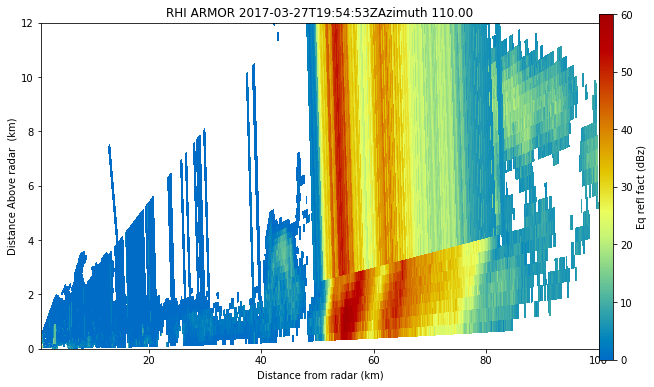

In [50]:
# Plot RHI
import netCDF4
display = pyart.graph.RadarDisplay(radarobj_RHI)

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)

instrument_name = radarobj_RHI.metadata['instrument_name']
time_start = netCDF4.num2date(radarobj_RHI.time['data'][0], radarobj_RHI.time['units'])
time_text = ' ' + time_start.strftime('%Y-%m-%dT%H:%M:%SZ')
azimuth = radarobj_RHI.fixed_angle['data'][-1]
title = 'RHI ' + instrument_name + time_text + 'Azimuth %.2f' % (azimuth)

display.plot('DBZ', 2, cmap='pyart_HomeyerRainbow', vmin=0., vmax=60, 
             title=title, colorbar_flag=False, ax=ax)
display.set_limits(ylim=[0, 12])

cax = fig.add_axes([.9, .1, 0.02, .8])
colorbar_label = 'Eq refl fact (dBz)'
display.plot_colorbar(fig=fig, cax=cax, label=colorbar_label)

plt.show()

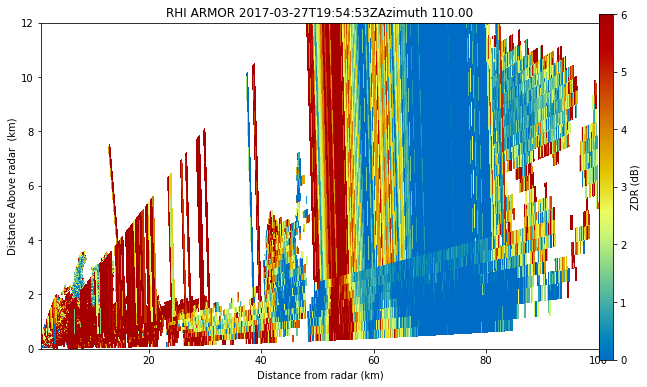

In [55]:
# Plot RHI (ZDR)
display = pyart.graph.RadarDisplay(radarobj_RHI)

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)

instrument_name = radarobj_RHI.metadata['instrument_name']
time_start = netCDF4.num2date(radarobj_RHI.time['data'][0], radarobj_RHI.time['units'])
time_text = ' ' + time_start.strftime('%Y-%m-%dT%H:%M:%SZ')
azimuth = radarobj_RHI.fixed_angle['data'][-1]
title = 'RHI ' + instrument_name + time_text + 'Azimuth %.2f' % (azimuth)

display.plot('ZDR', 2, cmap='pyart_HomeyerRainbow', vmin=0., vmax=6, 
             title=title, colorbar_flag=False, ax=ax)
display.set_limits(ylim=[0, 12])

cax = fig.add_axes([.9, .1, 0.02, .8])
colorbar_label = 'ZDR (dB)'
display.plot_colorbar(fig=fig, cax=cax, label=colorbar_label)

plt.show()

In [77]:
nexrad_radar_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW/0327/HTX/CFRadial/'
nexrad_radar_filename = 'cfrad.20170327_202501.696_to_20170327_202856.380_KHTX_Surveillance_SUR.nc'
nexrad_radar_path = os.path.join(nexrad_radar_dir, nexrad_radar_filename)
nexrad_radarobj = pyart.io.read_cfradial(nexrad_radar_path)

In [78]:
elevs = nexrad_radarobj.elevation['data']
elev_list = []
for elev in nexrad_radarobj.iter_elevation():
    print(elev[-1])
    elev_list.append(elev[-1])

nexrad_radarsweep = nexrad_radarobj.extract_sweeps([0])
print(nexrad_radarsweep.elevation['data'])

0.87890625
1.3183594
1.8017578
2.3428345
3.1201172
0.48339844
3.9990234
5.053711
6.4160156
7.918396
9.975586
12.436523
15.600586
19.467773
[0.83496094 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094
 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094
 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094
 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094
 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094 0.83496094
 0.83496094 0.83496094 0.83496094 0.8706665  0.8734131  0.8898926
 0.89263916 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625
 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625
 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625
 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625
 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625
 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625
 0.87890625 0.87890625 0.87890625 0.87890625 0.87890625 0.

Time:  2017-03-27T20:25:01Z
Elevation:  0.87890625


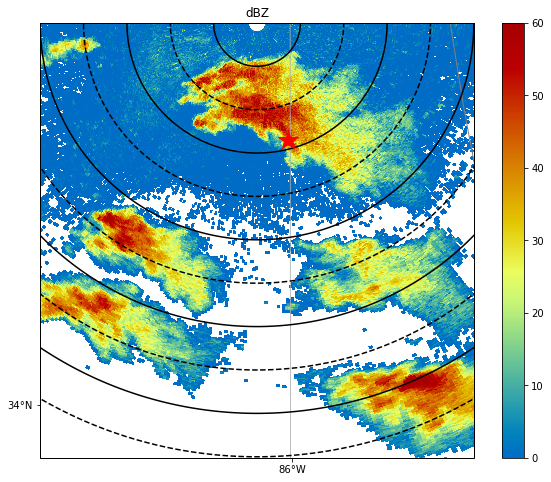

In [79]:
nexrad_sweeptime = nexrad_radarsweep.metadata['start_datetime']
display = pyart.graph.RadarMapDisplay(nexrad_radarsweep)
fig = plt.figure(figsize=(10, 8))

projection = ccrs.LambertConformal(central_latitude=nexrad_radarsweep.latitude['data'][0],
                                   central_longitude=nexrad_radarsweep.longitude['data'][0])

ax = fig.add_subplot(111)
print("Time: ", nexrad_sweeptime)
print("Elevation: ", nexrad_radarsweep.elevation['data'][-1])
display.plot_ppi_map('REF', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
                     vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                     fig=fig)
display.ax.set_extent([-50000, 50000, -100000, 0], crs=projection)
display.plot_range_ring(10., line_style='k-')
display.plot_range_ring(20., line_style='k--')
display.plot_range_ring(30., line_style='k-')
display.plot_range_ring(40., line_style='k--')
display.plot_range_ring(50., line_style='k-')
display.plot_range_ring(60., line_style='k--')
display.plot_range_ring(70., line_style='k-')
display.plot_range_ring(80., line_style='k--')
display.plot_range_ring(90., line_style='k-')
display.plot_range_ring(100., line_style='k--')
display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)

Time:  2017-03-27T20:25:01Z
Elevation:  0.87890625


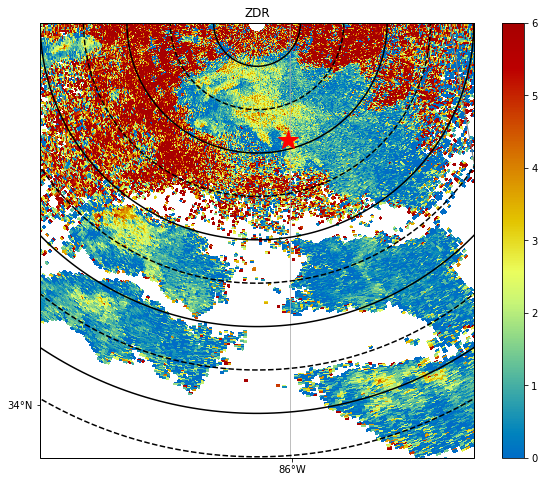

In [80]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
print("Time: ", nexrad_sweeptime)
print("Elevation: ", nexrad_radarsweep.elevation['data'][-1])
display.plot_ppi_map('ZDR', 0, title='ZDR', cmap='pyart_HomeyerRainbow',
                     vmin=0., vmax=6, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                     fig=fig)
display.ax.set_extent([-50000, 50000, -100000, 0], crs=projection)
display.plot_range_ring(10., line_style='k-')
display.plot_range_ring(20., line_style='k--')
display.plot_range_ring(30., line_style='k-')
display.plot_range_ring(40., line_style='k--')
display.plot_range_ring(50., line_style='k-')
display.plot_range_ring(60., line_style='k--')
display.plot_range_ring(70., line_style='k-')
display.plot_range_ring(80., line_style='k--')
display.plot_range_ring(90., line_style='k-')
display.plot_range_ring(100., line_style='k--')
display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)

In [ ]:
# OLD CELLS BELOW

In [ ]:
import pyart
import cartopy.crs as ccrs

for sweeptime, radar_obj in zip(radar_dict['sweeptimelist'][:1], radar_dict['radarsweeplist'][:1]):
    
#     rhoHV_ref_filter = pyart.correct.moment_based_gate_filter(radar_obj, rhv_field='RHO', refl_field='REF',
#                                                               min_ncp=None, min_rhv=0.95,
#                                                               min_refl=5., max_refl=None) 
    #print(rhoHV_filter.gate_excluded)
#    radar_obj.fields['ZDR']['data'] = np.ma.masked_where(rhoHV_ref_filter.gate_excluded, radar_obj.fields['ZDR']['data'])
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    display = pyart.graph.RadarMapDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    projection = ccrs.LambertConformal(central_latitude=radar_obj.latitude['data'][0],
                                       central_longitude=radar_obj.longitude['data'][0])
    
#     projection = ccrs.LambertConformal(central_latitude=PIPS_lat,
#                                        central_longitude=PIPS_lon)
    # plot dBZ
    ax = fig.add_subplot(111)
    print("Time: ", sweeptime)
    print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('REF', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
#                          vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    # plot D0
#     ax = fig.add_subplot(111)
#     print("Time: ", radar_obj.metadata['start_datetime'])
#     print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('D0', 0, title='D0', cmap='viridis',
#                          vmin=0., vmax=4., colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
                         # min_lon=-88., max_lon=-86., min_lat=40., max_lat=41.)
    # plot ZDR
    
#     display.plot_ppi_map('ZDR_filtered', 0, title='ZDR', cmap='pyart_HomeyerRainbow',
#                          vmin=0, vmax=6, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    display.plot_ppi_map('RHO', 0, title='RHO', cmap='pyart_HomeyerRainbow',
                         vmin=0, vmax=1, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                         fig=fig)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-50, 50), ylim=(-50, 50), ax=ax)
    #display.set_limits(xlim=(-75, -55), ylim=(75, 95), ax=ax)
    #display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
    display.ax.set_extent([-100000, 100000, -100000, 100000], crs=projection)
    #display.ax.set_extent([40000, 90000, -30000, 20000], crs=projection)
    #ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*', ms=20)
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [ ]:
from scipy.signal import medfilt2d

for sweeptime, radar_obj in zip(radar_dict['sweeptimelist'][:1], radar_dict['radarsweeplist'][:1]):

    rhoHV_ref_filter = pyart.correct.moment_based_gate_filter(radar_obj, rhv_field='RHO', refl_field='REF',
                                                              min_ncp=None, min_rhv=0.95, min_refl=5.0, 
                                                              max_refl=None)
    
#     rhoHV_ref_filter = pyart.correct.moment_based_gate_filter(radar_obj, rhv_field='RHO', refl_field='REF',
#                                                               min_ncp=None, min_rhv=0.95,
#                                                               min_refl=5., max_refl=None) 
    #print(rhoHV_filter.gate_excluded)
#    radar_obj.fields['ZDR']['data'] = np.ma.masked_where(rhoHV_ref_filter.gate_excluded, radar_obj.fields['ZDR']['data'])
    
    radar_obj.add_field_like('REF', 'REF_filtered2',
                             radar_obj.fields['REF']['data'].copy(), replace_existing=True)

    radar_obj.fields['REF_filtered2']['data'] = \
        medfilt2d(radar_obj.fields['REF_filtered2']['data'], kernel_size=3)
    
    radar_obj.add_field_like('RHO', 'RHO_filtered2',
                             radar_obj.fields['RHO']['data'].copy(), replace_existing=True)

    radar_obj.fields['RHO_filtered2']['data'] = \
        medfilt2d(radar_obj.fields['RHO_filtered2']['data'], kernel_size=3)
    
    rhoHV_ref_filter = pyart.correct.moment_based_gate_filter(radar_obj, rhv_field='RHO_filtered2', 
                                                              refl_field='REF_filtered2',
                                                              min_ncp=None, min_rhv=0.95, min_refl=5.0, 
                                                              max_refl=None)
    
    radar_obj.fields['RHO_filtered2']['data'] = \
        np.ma.masked_where(rhoHV_ref_filter.gate_excluded,
                           radar_obj.fields['RHO_filtered2']['data'])
    
#     mask = radar_obj.fields['RHO_filtered2']['data'].mask

#     radar_obj.fields['RHO_filtered2']['data'] = \
#         medfilt2d(radar_obj.fields['RHO_filtered2']['data'], kernel_size=3)

#     radar_obj.fields['RHO_filtered2']['data'] = \
#         np.ma.masked_array(data=radar_obj.fields['RHO_filtered2']['data'],
#                            mask=mask)

    
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    display = pyart.graph.RadarMapDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    projection = ccrs.LambertConformal(central_latitude=radar_obj.latitude['data'][0],
                                       central_longitude=radar_obj.longitude['data'][0])
    
#     projection = ccrs.LambertConformal(central_latitude=PIPS_lat,
#                                        central_longitude=PIPS_lon)
    # plot dBZ
    ax = fig.add_subplot(111)
    print("Time: ", sweeptime)
    print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('REF', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
#                          vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    # plot D0
#     ax = fig.add_subplot(111)
#     print("Time: ", radar_obj.metadata['start_datetime'])
#     print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('D0', 0, title='D0', cmap='viridis',
#                          vmin=0., vmax=4., colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
                         # min_lon=-88., max_lon=-86., min_lat=40., max_lat=41.)
    # plot ZDR
    
#     display.plot_ppi_map('ZDR_filtered', 0, title='ZDR', cmap='pyart_HomeyerRainbow',
#                          vmin=0, vmax=6, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    display.plot_ppi_map('RHO_filtered2', 0, title='RHO', cmap='pyart_HomeyerRainbow',
                         vmin=0, vmax=1, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                         fig=fig)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-50, 50), ylim=(-50, 50), ax=ax)
    #display.set_limits(xlim=(-75, -55), ylim=(75, 95), ax=ax)
    #display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
    display.ax.set_extent([-100000, 100000, -100000, 100000], crs=projection)
    #display.ax.set_extent([40000, 90000, -30000, 20000], crs=projection)
    #ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*', ms=20)
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [ ]:
for sweeptime, radar_obj in zip(radar_dict['sweeptimelist'][:1], radar_dict['radarsweeplist'][:1]):
    
#     rhoHV_ref_filter = pyart.correct.moment_based_gate_filter(radar_obj, rhv_field='RHO', refl_field='REF',
#                                                               min_ncp=None, min_rhv=0.95,
#                                                               min_refl=5., max_refl=None) 
    #print(rhoHV_filter.gate_excluded)
#    radar_obj.fields['ZDR']['data'] = np.ma.masked_where(rhoHV_ref_filter.gate_excluded, radar_obj.fields['ZDR']['data'])
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    display = pyart.graph.RadarMapDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    projection = ccrs.LambertConformal(central_latitude=radar_obj.latitude['data'][0],
                                       central_longitude=radar_obj.longitude['data'][0])
    
#     projection = ccrs.LambertConformal(central_latitude=PIPS_lat,
#                                        central_longitude=PIPS_lon)
    # plot dBZ
    ax = fig.add_subplot(111)
    print("Time: ", sweeptime)
    print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('REF', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
#                          vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    # plot D0
#     ax = fig.add_subplot(111)
#     print("Time: ", radar_obj.metadata['start_datetime'])
#     print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('D0', 0, title='D0', cmap='viridis',
#                          vmin=0., vmax=4., colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
                         # min_lon=-88., max_lon=-86., min_lat=40., max_lat=41.)
    # plot ZDR
    
#     display.plot_ppi_map('ZDR_filtered', 0, title='ZDR', cmap='pyart_HomeyerRainbow',
#                          vmin=0, vmax=6, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    display.plot_ppi_map('RHO_filtered', 0, title='RHO', cmap='pyart_HomeyerRainbow',
                         vmin=0, vmax=1, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                         fig=fig)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-50, 50), ylim=(-50, 50), ax=ax)
    #display.set_limits(xlim=(-75, -55), ylim=(75, 95), ax=ax)
    #display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
    display.ax.set_extent([-100000, 100000, -100000, 100000], crs=projection)
    #display.ax.set_extent([40000, 90000, -30000, 20000], crs=projection)
    #ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*', ms=20)
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [ ]:
for radar_obj in radar_dict['radarsweeplist'][:1]:
    radar_obj.add_field_like('ZDR', 'ZDR_smooth', \
                             radar_obj.fields['ZDR']['data'].copy(), replace_existing=True)
    radar_obj.fields['ZDR_smooth']['data'] = medfilt2d(radar_obj.fields['ZDR_smooth']['data'])
    radar_obj.fields['ZDR_smooth']['data'] = np.ma.masked_array(data = radar_obj.fields['ZDR_smooth']['data'], 
                                                                mask = radar_obj.fields['ZDR']['data'].mask)
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    display = pyart.graph.RadarMapDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    projection = ccrs.LambertConformal(central_latitude=radar_obj.latitude['data'][0],
                                       central_longitude=radar_obj.longitude['data'][0])
    
#     projection = ccrs.LambertConformal(central_latitude=PIPS_lat,
#                                        central_longitude=PIPS_lon)
    # plot dBZ
    ax = fig.add_subplot(111)
    print("Time: ", radar_obj.metadata['start_datetime'])
    print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('REF', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
#                          vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    # plot D0
#     ax = fig.add_subplot(111)
#     print("Time: ", radar_obj.metadata['start_datetime'])
#     print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('D0', 0, title='D0', cmap='viridis',
#                          vmin=0., vmax=4., colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
                         # min_lon=-88., max_lon=-86., min_lat=40., max_lat=41.)
    # plot ZDR
    
    display.plot_ppi_map('ZDR_smooth', 0, title='ZDR (smooth)', cmap='pyart_HomeyerRainbow',
                         vmin=0, vmax=6, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                         fig=fig)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-50, 50), ylim=(-50, 50), ax=ax)
    #display.set_limits(xlim=(-75, -55), ylim=(75, 95), ax=ax)
    #display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
    display.ax.set_extent([40000, 90000, -30000, 20000], crs=projection)
    #ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*', ms=20)
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [ ]:
for radar_obj in radar_dict['radarsweeplist'][:1]:
    
    kdp, _, _ = pyart.retrieve.kdp_schneebeli(radar_obj, kdp_field='KDP', psidp_field='PHI', 
                                              band='S')
    
    radar_obj.add_field('KDP', kdp, replace_existing=True)
    
#     rhoHV_ref_filter = pyart.correct.moment_based_gate_filter(radar_obj, rhv_field='RHO', refl_field='REF',
#                                                               min_ncp=None, min_rhv=0.95,
#                                                               min_refl=5., max_refl=None) 
    #print(rhoHV_filter.gate_excluded)
#    radar_obj.fields['ZDR']['data'] = np.ma.masked_where(rhoHV_ref_filter.gate_excluded, radar_obj.fields['ZDR']['data'])
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    display = pyart.graph.RadarMapDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    projection = ccrs.LambertConformal(central_latitude=radar_obj.latitude['data'][0],
                                       central_longitude=radar_obj.longitude['data'][0])
    
#     projection = ccrs.LambertConformal(central_latitude=PIPS_lat,
#                                        central_longitude=PIPS_lon)
    # plot dBZ
    ax = fig.add_subplot(111)
    print("Time: ", radar_obj.metadata['start_datetime'])
    print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('REF', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
#                          vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    # plot D0
#     ax = fig.add_subplot(111)
#     print("Time: ", radar_obj.metadata['start_datetime'])
#     print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('D0', 0, title='D0', cmap='viridis',
#                          vmin=0., vmax=4., colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
                         # min_lon=-88., max_lon=-86., min_lat=40., max_lat=41.)
    # plot KDP
    
    display.plot_ppi_map('KDP', 0, title='KDP',
                         vmin=0, vmax=6, colorbar_label='', ax=ax, resolution='10m', projection=projection,
                         fig=fig)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-50, 50), ylim=(-50, 50), ax=ax)
    #display.set_limits(xlim=(-75, -55), ylim=(75, 95), ax=ax)
    #display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
    display.ax.set_extent([40000, 90000, -30000, 20000], crs=projection)
    #ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*', ms=20)
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [ ]:
sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/soundings/NWSRAOB/'
sounding_name = 'BMX_043016_0Z.txt'
sounding_path = os.path.join(sounding_dir, sounding_name)
sounding = pd.read_csv(sounding_path,header=[1,2],delim_whitespace=True,skiprows=[3,4])
hght = np.array(sounding["HGHT"]).squeeze()
temp = np.array(sounding["TEMP"]).squeeze()

In [ ]:
for radar_obj in radar_dict['radarsweeplist'][:1]:
    h_dict, t_dict = pyart.retrieve.map_profile_to_gates(temp, hght, radar_obj)
    radar_obj.add_field('sounding_temperature', t_dict, replace_existing=True)
    radar_obj.add_field('height', h_dict, replace_existing=True)
    
    hydro_class = pyart.retrieve.hydroclass_semisupervised(radar_obj, refl_field='REF', zdr_field='ZDR', 
                                                           rhv_field='RHO', kdp_field='KDP', temp_field='sounding_temperature', 
                                                           hydro_field='radar_echo_classification')
    radar_obj.add_field('radar_echo_classification', hydro_class, replace_existing=True)
#     rhoHV_ref_filter = pyart.correct.moment_based_gate_filter(radar_obj, rhv_field='RHO', refl_field='REF',
#                                                               min_ncp=None, min_rhv=0.95,
#                                                               min_refl=5., max_refl=None) 
    #print(rhoHV_filter.gate_excluded)
#    radar_obj.fields['ZDR']['data'] = np.ma.masked_where(rhoHV_ref_filter.gate_excluded, radar_obj.fields['ZDR']['data'])
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    display = pyart.graph.RadarMapDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    projection = ccrs.LambertConformal(central_latitude=radar_obj.latitude['data'][0],
                                       central_longitude=radar_obj.longitude['data'][0])
    
#     projection = ccrs.LambertConformal(central_latitude=PIPS_lat,
#                                        central_longitude=PIPS_lon)
    # plot dBZ
    ax = fig.add_subplot(111)
    print("Time: ", radar_obj.metadata['start_datetime'])
    print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('REF', 0, title='dBZ', cmap='pyart_HomeyerRainbow',
#                          vmin=0., vmax=60, colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
    # plot D0
#     ax = fig.add_subplot(111)
#     print("Time: ", radar_obj.metadata['start_datetime'])
#     print("Elevation: ", radar_obj.elevation['data'][-1])
#     display.plot_ppi_map('D0', 0, title='D0', cmap='viridis',
#                          vmin=0., vmax=4., colorbar_label='', ax=ax, resolution='10m', projection=projection,
#                          fig=fig)
                         # min_lon=-88., max_lon=-86., min_lat=40., max_lat=41.)
    # plot ZDR

    display.plot_ppi_map('radar_echo_classification', 0, title='radar_echo_classification', 
                         ax=ax, resolution='10m', projection=projection,
                         fig=fig)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-50, 50), ylim=(-50, 50), ax=ax)
    #display.set_limits(xlim=(-75, -55), ylim=(75, 95), ax=ax)
    #display.plot_point(PIPS_lon, PIPS_lat, 'r*', ms=20)
    display.ax.set_extent([40000, 90000, -30000, 20000], crs=projection)
    #ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*', ms=20)
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()